In [2]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 69.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=1a8bff643880257d1266d29f331b2f0a3c9d6962e183c6c8bb061c9877038827
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=63de951eea089a8dc0ad600e64efee9a4f87288d9ac52561d173d3f53d966a18
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

In [3]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as TF
from segmentation_models_pytorch import PSPNet
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

# Dataset Preparation
class SegmentationDataset(Dataset):
    def __init__(self, image_folder, mask_folder, transform=None):
        """
        Custom dataset for segmentation tasks.

        Args:
            image_folder (str): Path to the folder containing input images.
            mask_folder (str): Path to the folder containing ground truth masks.
            transform (callable, optional): Transformations to apply on the images and masks.
        """
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.transform = transform

        # Filter images to include only those with corresponding masks
        image_files = set(os.listdir(image_folder))
        mask_files = set(os.listdir(mask_folder))

        # Match images and masks by their base filenames (without extensions)
        self.image_filenames = sorted([
            img for img in image_files if os.path.splitext(img)[0] in {
                os.path.splitext(mask)[0] for mask in mask_files
            }
        ])
        self.mask_filenames = sorted([
            mask for mask in mask_files if os.path.splitext(mask)[0] in {
                os.path.splitext(img)[0] for img in image_files
            }
        ])

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        """
        Load and preprocess an image-mask pair.

        Args:
            idx (int): Index of the data point.

        Returns:
            dict: Processed image and corresponding mask.
        """
        image_path = os.path.join(self.image_folder, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_folder, self.mask_filenames[idx])

        # Load image and mask
        image = TF.to_tensor(Image.open(image_path).convert("RGB"))
        mask = torch.tensor(np.array(Image.open(mask_path)), dtype=torch.long)

        # Normalize mask to binary values (0 and 1) if it's binary segmentation
        mask = (mask > 0).long()

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


# Define Paths
IMAGE_FOLDER = "/kaggle/input/dataset/train/images"  
MASK_FOLDER = "/kaggle/input/dataset/train/masks" 

# Dataset and DataLoader
dataset = SegmentationDataset(IMAGE_FOLDER, MASK_FOLDER)

# Split dataset into training, validation, and testing sets
train_val_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
train_indices, val_indices = train_test_split(train_val_indices, test_size=0.2, random_state=42)

# Create subset datasets
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Define PSPNet Model
model = PSPNet(
    encoder_name="resnet34",         # Backbone
    encoder_weights="imagenet",     # Pre-trained weights
    in_channels=3,                  # RGB input
    classes=2                       # Binary segmentation (1 class + background)
)

# Move model to device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class segmentation
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training and Validation Loop
num_epochs = 20
best_loss = float("inf")
best_model_path = "./best_pspnet_model.pth"

for epoch in range(num_epochs):
    # Training Loop
    model.train()
    train_loss = 0
    for images, masks in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_dataloader)

    # Validation Loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in tqdm(val_dataloader, desc=f"Validation Epoch {epoch+1}"):
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    val_loss /= len(val_dataloader)

    # Log results
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Save the best model
    if val_loss < best_loss:
        best_loss = val_loss
        # # Save the model weights after training
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved with validation loss: {best_loss:.4f}")

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 464MB/s]
Validation Epoch 1: 100%|██████████| 69/69 [00:09<00:00,  7.56it/s]


Epoch 1/20, Train Loss: 0.1312, Validation Loss: 0.0728
Best model saved with validation loss: 0.0728


Validation Epoch 2: 100%|██████████| 69/69 [00:03<00:00, 18.60it/s]


Epoch 2/20, Train Loss: 0.0629, Validation Loss: 0.0559
Best model saved with validation loss: 0.0559


Validation Epoch 3: 100%|██████████| 69/69 [00:04<00:00, 17.16it/s]


Epoch 3/20, Train Loss: 0.0522, Validation Loss: 0.0489
Best model saved with validation loss: 0.0489


Validation Epoch 4: 100%|██████████| 69/69 [00:03<00:00, 18.61it/s]


Epoch 4/20, Train Loss: 0.0449, Validation Loss: 0.0465
Best model saved with validation loss: 0.0465


Validation Epoch 5: 100%|██████████| 69/69 [00:03<00:00, 17.88it/s]


Epoch 5/20, Train Loss: 0.0405, Validation Loss: 0.0423
Best model saved with validation loss: 0.0423


Validation Epoch 6: 100%|██████████| 69/69 [00:03<00:00, 19.91it/s]


Epoch 6/20, Train Loss: 0.0378, Validation Loss: 0.0435


Validation Epoch 7: 100%|██████████| 69/69 [00:03<00:00, 19.68it/s]


Epoch 7/20, Train Loss: 0.0364, Validation Loss: 0.0416
Best model saved with validation loss: 0.0416


Validation Epoch 8: 100%|██████████| 69/69 [00:03<00:00, 19.53it/s]


Epoch 8/20, Train Loss: 0.0335, Validation Loss: 0.0392
Best model saved with validation loss: 0.0392


Validation Epoch 9: 100%|██████████| 69/69 [00:03<00:00, 20.13it/s]


Epoch 9/20, Train Loss: 0.0316, Validation Loss: 0.0397


Validation Epoch 10: 100%|██████████| 69/69 [00:03<00:00, 18.25it/s]


Epoch 10/20, Train Loss: 0.0296, Validation Loss: 0.0363
Best model saved with validation loss: 0.0363


Validation Epoch 11: 100%|██████████| 69/69 [00:03<00:00, 19.49it/s]


Epoch 11/20, Train Loss: 0.0280, Validation Loss: 0.0388


Validation Epoch 12: 100%|██████████| 69/69 [00:03<00:00, 20.34it/s]


Epoch 12/20, Train Loss: 0.0264, Validation Loss: 0.0387


Validation Epoch 13: 100%|██████████| 69/69 [00:03<00:00, 19.74it/s]


Epoch 13/20, Train Loss: 0.0262, Validation Loss: 0.0462


Validation Epoch 14: 100%|██████████| 69/69 [00:03<00:00, 19.85it/s]


Epoch 14/20, Train Loss: 0.0245, Validation Loss: 0.0373


Validation Epoch 15: 100%|██████████| 69/69 [00:03<00:00, 18.89it/s]


Epoch 15/20, Train Loss: 0.0239, Validation Loss: 0.0384


Validation Epoch 16: 100%|██████████| 69/69 [00:03<00:00, 18.87it/s]


Epoch 16/20, Train Loss: 0.0224, Validation Loss: 0.0394


Validation Epoch 17: 100%|██████████| 69/69 [00:03<00:00, 18.08it/s]


Epoch 17/20, Train Loss: 0.0216, Validation Loss: 0.0409


Validation Epoch 18: 100%|██████████| 69/69 [00:03<00:00, 18.80it/s]


Epoch 18/20, Train Loss: 0.0211, Validation Loss: 0.0392


Validation Epoch 19: 100%|██████████| 69/69 [00:03<00:00, 19.94it/s]


Epoch 19/20, Train Loss: 0.0210, Validation Loss: 0.0399


Validation Epoch 20: 100%|██████████| 69/69 [00:03<00:00, 18.42it/s]

Epoch 20/20, Train Loss: 0.0192, Validation Loss: 0.0411


In [5]:
# Evaluate the Model on the Test Dataset
model.load_state_dict(torch.load("./best_pspnet_model.pth", weights_only=True))
model.eval()

# Define a function to compute IoU, Dice, and Pixel Accuracy
def compute_metrics(preds, masks, threshold=0.5):
    preds = (preds > threshold).int()
    masks = masks.int()

    intersection = (preds & masks).float().sum((1, 2))
    union = (preds | masks).float().sum((1, 2))

    iou = (intersection / union).mean().item()
    dice = (2 * intersection / (preds.float().sum((1, 2)) + masks.float().sum((1, 2)))).mean().item()
    pixel_accuracy = (preds == masks).float().mean().item()

    return iou, dice, pixel_accuracy

# Test Loop
iou_scores, dice_scores, pixel_accuracies = [], [], []
with torch.no_grad():
    for images, masks in tqdm(test_dataloader, desc="Testing"):
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        iou, dice, pixel_acc = compute_metrics(preds, masks)
        iou_scores.append(iou)
        dice_scores.append(dice)
        pixel_accuracies.append(pixel_acc)

# Report Mean Metrics
print(f"Test IoU: {np.mean(iou_scores):.4f}")
print(f"Test Dice Coefficient: {np.mean(dice_scores):.4f}")
print(f"Test Pixel Accuracy: {np.mean(pixel_accuracies):.4f}")

Testing: 100%|██████████| 86/86 [00:04<00:00, 18.16it/s]

Test IoU: 0.9071
Test Dice Coefficient: 0.9509
Test Pixel Accuracy: 0.9857


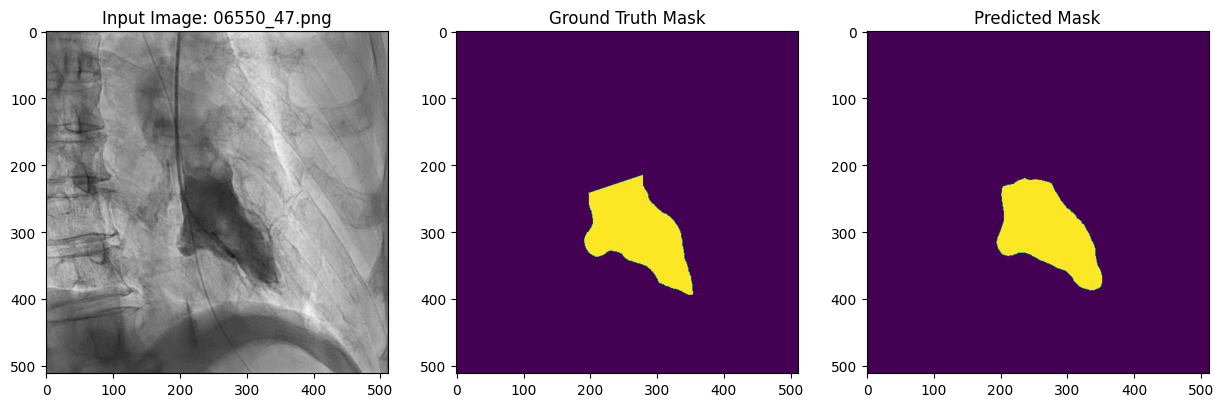

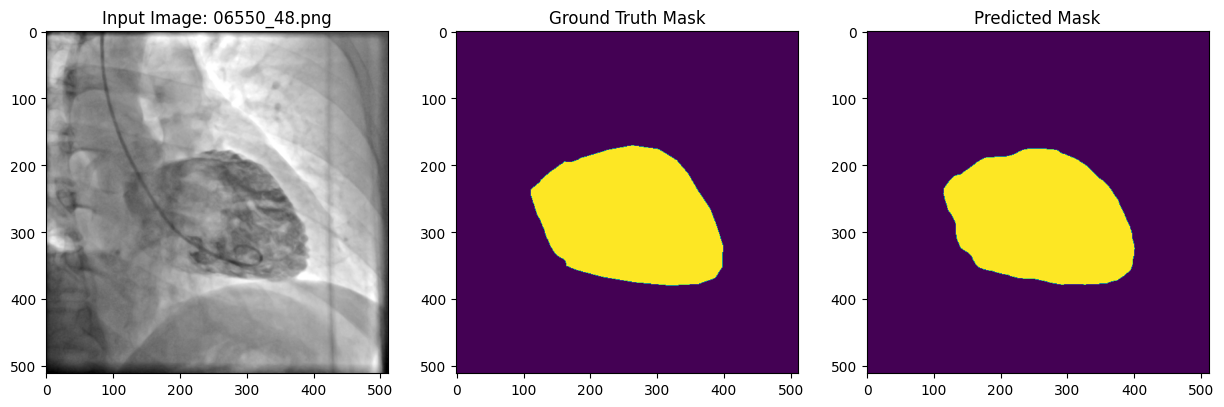

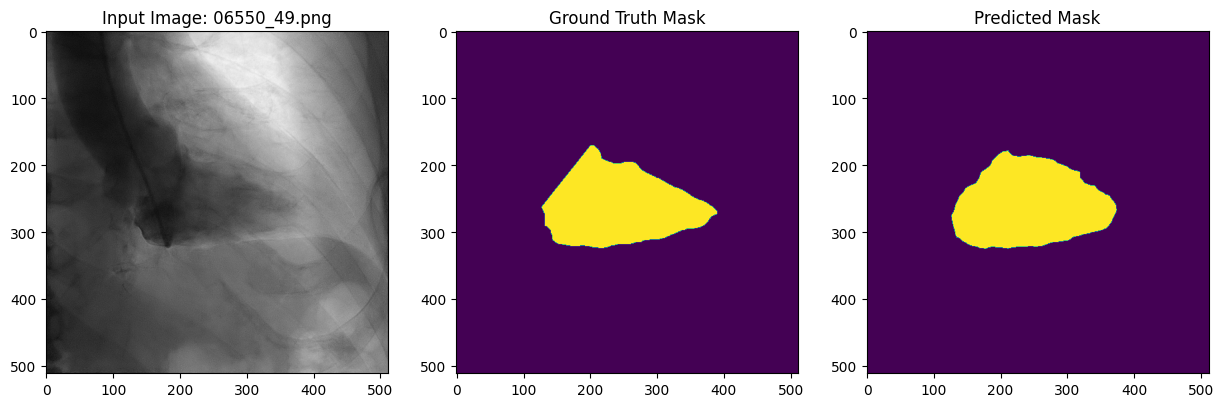

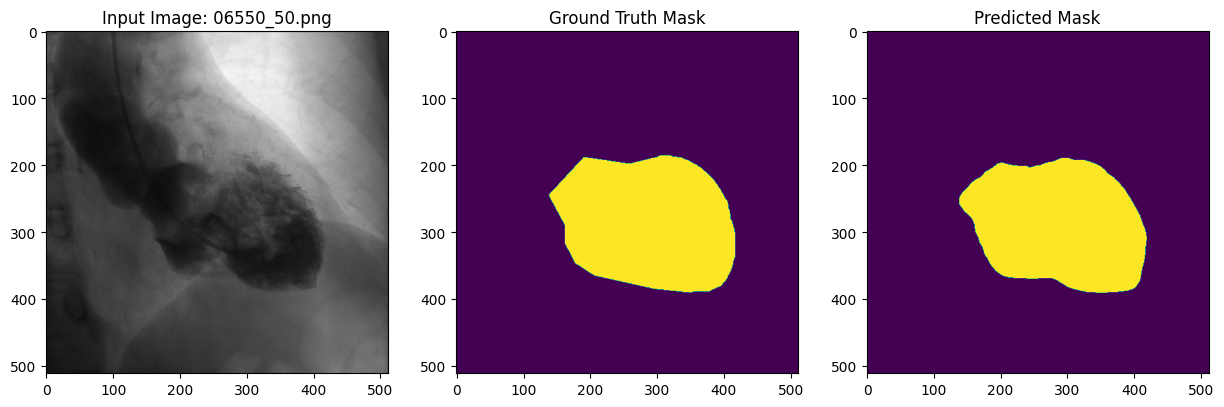

In [7]:
# Visualize Results
def visualize_results(dataloader, model, device, dataset):
    """
    Visualize input images, ground truth masks, and predictions with image filenames.

    Args:
        dataloader (DataLoader): DataLoader for the dataset.
        model (nn.Module): Trained model for segmentation.
        device (str): Device (CPU or GPU) to run the model on.
        dataset (Dataset): Dataset object to get filenames.
    """
    model.eval()
    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(dataloader):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            for i in range(len(images)):
                # Get the image filename
                image_idx = batch_idx * dataloader.batch_size + i
                filename = dataset.image_filenames[image_idx]

                # Visualize results
                plt.figure(figsize=(15, 5))
                plt.subplot(1, 3, 1)
                plt.imshow(images[i].cpu().permute(1, 2, 0))
                plt.title(f"Input Image: {filename}")

                plt.subplot(1, 3, 2)
                plt.imshow(masks[i].cpu())
                plt.title("Ground Truth Mask")

                plt.subplot(1, 3, 3)
                plt.imshow(preds[i].cpu())
                plt.title("Predicted Mask")

                plt.show()
            break  # Visualize only the first batch for efficiency

visualize_results(test_dataloader, model, device, dataset)